In [62]:
#import all the required packages...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns.fpgrowth import fpgrowth
%matplotlib inline

### Loading dataset

In [88]:
# loading dataset and storing as pandas dataframe as 'customer_data'
customer_data = pd.read_csv('data.csv')
customer_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


The above table shows the overview of the dataset. It has information about transactions of customers from different countries.
One customer can purchase different products(Description) with multiple stockcodes, qunatity, unitprice with same InvoiceNo

In [89]:
# Dataset has 541909 instances and 8 attributes/cloumns
customer_data.shape

(541909, 8)

In [90]:
# Dataset has 5 categorical and 5 numeric data type attributes
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [91]:
# for further analysis the "InvoiceDate" attribute is converted into specifif date format using datetime
customer_data.InvoiceDate = pd.to_datetime(customer_data.InvoiceDate)

In [92]:
# the InvoiceDate is converted into desired format
customer_data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
96155,544479,21843,RED RETROSPOT CAKE STAND,24,2011-02-21 10:28:00,9.95,14646.0,Netherlands
442939,574683,22424,ENAMEL BREAD BIN CREAM,1,2011-11-06 12:50:00,12.75,16372.0,United Kingdom
10067,537224,21813,GARLAND WITH STARS AND BELLS,6,2010-12-05 16:24:00,4.95,13174.0,United Kingdom
176210,551997,22725,ALARM CLOCK BAKELIKE CHOCOLATE,1,2011-05-05 15:47:00,7.46,NaN,United Kingdom
439708,574481,23308,SET OF 60 VINTAGE LEAF CAKE CASES,1,2011-11-04 12:45:00,0.55,18022.0,United Kingdom


### Handling missing values

In [93]:
# checking missing values in the data
customer_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Both Description and CustomerID has missing values which needs to be handled

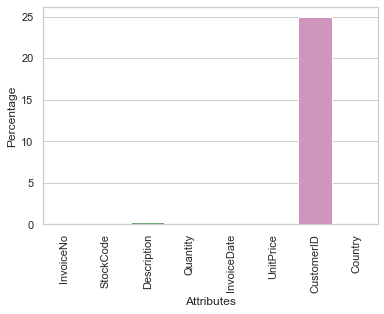

In [94]:
# plotting missing values
missing_per=customer_data.isnull().sum()/customer_data.shape[0] *100
missing_per=missing_per.to_frame()
missing_per.columns = ['Percentage']
missing_per.index.names = ['Attributes']
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = missing_per.index, y = 'Percentage', data=missing_per)
plt.xticks(rotation = 90)
plt.show()

From the above bar graph, the CustomerID has almost 25% of missing values and Description has less than 0.5% of missing values

In [9]:
customer_data.InvoiceNo.value_counts()

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
544043        1
C579913       1
C569490       1
557417        1
C546978       1
Name: InvoiceNo, Length: 25900, dtype: int64

In [10]:
customer_data.Description.nunique()

4223

In [11]:
customer_data.Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
                                      ... 
BREAD BIN, DINER STYLE, IVORY            1
damages/showroom etc                     1
20713                                    1
VINTAGE GOLD TINSEL REEL                 1
SET 10 CARDS TRIANGLE ICONS  17220       1
Name: Description, Length: 4223, dtype: int64

There are some instances where InvoiceNo starts with 'C', which means cancelled transactions. We need to drop those instances and others if any from our dataset

In [12]:
customer_data.drop(customer_data[customer_data.InvoiceNo.str.match('^[a-zA-Z]')].index, axis=0, inplace=True)

In [13]:
customer_data.InvoiceNo.str.match('^[a-zA-Z]').value_counts()

False    532618
Name: InvoiceNo, dtype: int64

Now we can see there are no instances of cancelled transactions

In [14]:
# converting the data type of invoice no to int
customer_data.InvoiceNo = customer_data.InvoiceNo.astype('int64')

In [15]:
# out of 54K instances there are only around 22K unique invoices, which shows that the customers purchase mutliple products with a single invoice
customer_data.InvoiceNo.nunique()

22061

In [16]:
customer_data.InvoiceNo.count()

532618

### Handling error values

In [17]:
(customer_data['Quantity'] <0).value_counts()

False    531282
True       1336
Name: Quantity, dtype: int64

The Qunatity attribute has 1K negative values, which should not be possible in real scenario

In [18]:
#Removing error values of attributes from the dataset
customer_data=customer_data[(customer_data.Quantity>0) & (customer_data.UnitPrice>0)]
customer_data.shape

(530103, 8)

After removing the error values we have around 53K isntances

In [19]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530103 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530103 non-null  int64         
 1   StockCode    530103 non-null  object        
 2   Description  530103 non-null  object        
 3   Quantity     530103 non-null  int64         
 4   InvoiceDate  530103 non-null  datetime64[ns]
 5   UnitPrice    530103 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530103 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 36.4+ MB


In [20]:
customer_data.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,530103.000000,530103.000000,530103.000000,397884.000000
mean,559981.474689,10.542055,3.886765,15294.423453
std,13430.049738,155.524270,32.546281,1713.141560
min,536365.000000,1.000000,0.001000,12346.000000
25%,547909.000000,1.000000,1.250000,13969.000000
50%,560711.000000,3.000000,2.080000,15159.000000
75%,571847.000000,10.000000,4.130000,16795.000000
max,581587.000000,80995.000000,13541.330000,18287.000000


In [21]:
# some spaces are there in description need to remove else later operation it will create problem..
customer_data['Description'] = customer_data['Description'].str.strip()

In [22]:
# Dropping the instances which has no description of products
customer_data.dropna(inplace=True, subset=['Description'])

In [23]:
customer_data.Description.isnull().sum()

0

### Exploratory data analysis and visualization

In [24]:
customer_data.Country.value_counts().head(5)

United Kingdom    485122
Germany             9040
France              8407
EIRE                7890
Spain               2484
Name: Country, dtype: int64

In [25]:
customer_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [26]:
co_cu=customer_data[['Country','CustomerID']].groupby('Country').count().sort_values(by="CustomerID",ascending=False).head(10)
co_cu

,CustomerID
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484
Netherlands,2359
Belgium,2031
Switzerland,1841
Portugal,1462


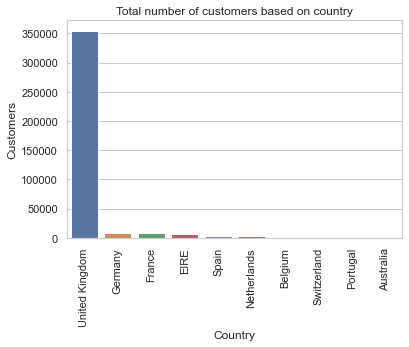

In [27]:
sns.barplot(x = co_cu.index, y = 'CustomerID', data=co_cu)
plt.title("Total number of customers based on country")
plt.ylabel("Customers")
plt.xlabel("Country")
plt.xticks(rotation = 90)
plt.show()

The above bar graph shows the top ten countries based on customers. United Kingdom has majority of customers followed by germany and france.

In [28]:
co_in=customer_data[['Country','InvoiceNo']].groupby('Country').count().sort_values(by="InvoiceNo",ascending=False).head(10)
co_in

,InvoiceNo
Country,
United Kingdom,485122
Germany,9040
France,8407
EIRE,7890
Spain,2484
Netherlands,2359
Belgium,2031
Switzerland,1966
Portugal,1501


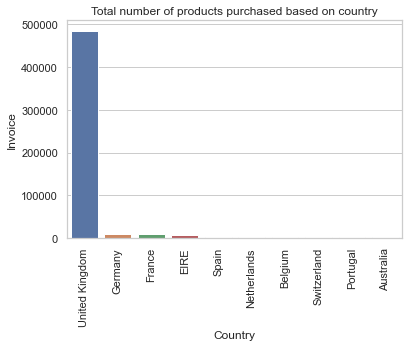

In [29]:
sns.barplot(x =co_in.index, y = 'InvoiceNo', data=co_in)
plt.title("Total number of products purchased based on country")
plt.xlabel("Country")
plt.ylabel("Invoice")
plt.xticks(rotation = 90)
plt.show()

The above bar graph shows the customers in United Kingdom has purchased more products when compared to other countries

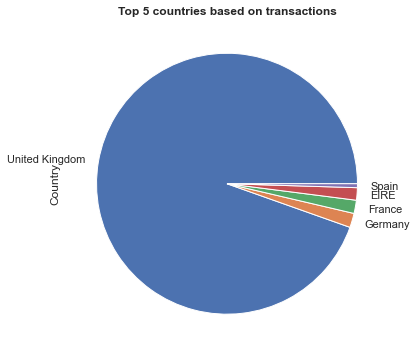

In [30]:
plt.figure(figsize=(10,6))
customer_data['Country'].value_counts()[:5].plot(kind = 'pie') 
plt.title('Top 5 countries based on transactions', weight='bold')
plt.show()

In [31]:
cu_pr=customer_data[['Quantity',"Description"]].groupby('Description').count().sort_values(by="Quantity",ascending=False)
cu_pr_top=cu_pr.head(10)
cu_pr_top

,Quantity
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2323
JUMBO BAG RED RETROSPOT,2112
REGENCY CAKESTAND 3 TIER,2017
PARTY BUNTING,1706
LUNCH BAG RED RETROSPOT,1594
ASSORTED COLOUR BIRD ORNAMENT,1489
SET OF 3 CAKE TINS PANTRY DESIGN,1399
PACK OF 72 RETROSPOT CAKE CASES,1370
LUNCH BAG BLACK SKULL.,1328


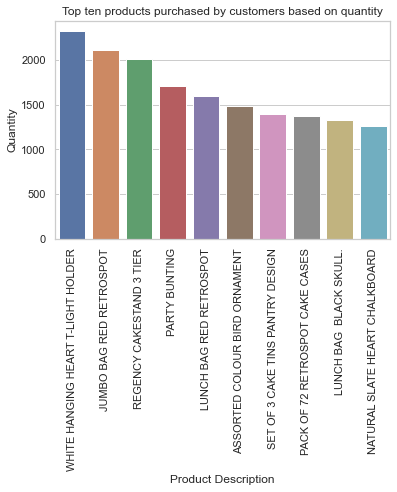

In [32]:
sns.barplot(x =cu_pr_top.index, y = 'Quantity', data=cu_pr_top)
plt.title("Top ten products purchased by customers based on quantity")
plt.xlabel("Product Description")
plt.ylabel("Quantity")
plt.xticks(rotation = 90)
plt.show()

The above graph shows that "WHITE HANGING HEART T-LIGHT HOLDER" is the most purchased product followed by "JUMBO BAG RED RETROSPOT" and "REGENCY CAKESTAND 3 TIER"

In [33]:
cu_pr_least=cu_pr.tail(10)
cu_pr_least

,Quantity
Description,
DOLPHIN WINDMILL,1
MINT DINER CLOCK,1
WHITE FRANGIPANI HAIR CLIP,1
BLUE GINGHAM ROSE CUSHION COVER,1
MISELTOE HEART WREATH CREAM,1
BLUE DROP EARRINGS W BEAD CLUSTER,1
SET/6 IVORY BIRD T-LIGHT CANDLES,1
MUMMY MOUSE RED GINGHAM RIBBON,1
SET/5 RED SPOTTY LID GLASS BOWLS,1


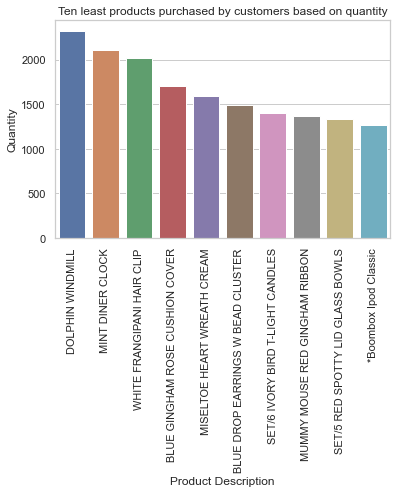

In [34]:
sns.barplot(x =cu_pr_least.index, y = 'Quantity', data=cu_pr_top)
plt.title("Ten least products purchased by customers based on quantity")
plt.xlabel("Product Description")
plt.ylabel("Quantity")
plt.xticks(rotation = 90)
plt.show()

DOLPHIN WINDMILL, MINT DINER CLOCK, WHITE FRANGIPANI HAIR CLIP, BLUE GINGHAM ROSE CUSHION COVER, etc are the least purchsed products by customers

In [35]:
# Since more than 90% of the transactions are done in United Kingdom, we will apply association rules on it.
customer_uk = customer_data[customer_data.Country == 'United Kingdom']
customer_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [36]:
customer_uk.shape

(485122, 8)

In [37]:
#convert data into a format which it require converting using pivot table and Quantity sum as values. fill 0 if any nan values

basket_uk= pd.pivot_table(data=customer_uk,index='InvoiceNo',columns='Description',values='Quantity',aggfunc='sum',fill_value=0)

In [38]:
basket_uk.sample(10)

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
564510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
562730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
577402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
575978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
554491,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
552271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,12,0,0,0,0
558892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
553053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
basket_uk['ASSORTED COLOUR BIRD ORNAMENT'].head()

InvoiceNo
536365     0
536366     0
536367    32
536368     0
536369     0
Name: ASSORTED COLOUR BIRD ORNAMENT, dtype: int64

We don't need the quantity of product. We only need whether the product is purchased by customer or not. 

In [40]:
def one_hot_encoding(value):
    if value > 0:
        return 1
    else:
        return 0

In [41]:
basket_uk = basket_uk.applymap(one_hot_encoding)

In [42]:
# The same item shown above has quantity now converted to 1 or 0.
basket_uk['ASSORTED COLOUR BIRD ORNAMENT'].head()

InvoiceNo
536365    0
536366    0
536367    1
536368    0
536369    0
Name: ASSORTED COLOUR BIRD ORNAMENT, dtype: int64

In [43]:
basket_uk['POSTAGE'].value_counts().head(10)

0    17966
1       52
Name: POSTAGE, dtype: int64

In [44]:
basket_uk.drop(columns=['POSTAGE'],inplace=True)

In [45]:
basket_uk.shape

(18018, 3994)

### Applying Apriori algorithm

In [79]:
#call apriori function and pass minimum support here we are passing 0.03%. means 3 times an item was present in total number of transactions.
frequent_itemsets = apriori(basket_uk, min_support=0.03, use_colnames=True, verbose=1)

Processing 162 combinations | Sampling itemset size 3 2


In [80]:
#it will generate frequent itemsets using two step approch
frequent_itemsets.head()

,support,itemsets
0,0.047453,(6 RIBBONS RUSTIC CHARM)
1,0.032246,(60 CAKE CASES VINTAGE CHRISTMAS)
2,0.041792,(60 TEATIME FAIRY CAKE CASES)
3,0.030803,(72 SWEETHEART FAIRY CAKE CASES)
4,0.048618,(ALARM CLOCK BAKELIKE GREEN)


In [81]:
rules_apriori = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules_apriori.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.048618,0.051615,0.031247,0.642694,12.451679,0.028737,2.654266
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.051615,0.048618,0.031247,0.605376,12.451679,0.028737,2.410859
2,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.041625,0.049839,0.030026,0.721333,14.473256,0.027951,3.409668
3,(GARDENERS KNEELING PAD KEEP CALM),(GARDENERS KNEELING PAD CUP OF TEA),0.049839,0.041625,0.030026,0.602450,14.473256,0.027951,2.410702
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038961,0.051726,0.031968,0.820513,15.862661,0.029953,5.283241


In [96]:
rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031968,0.820513,15.862661
5,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.031968,0.618026,15.862661
11,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.030248,0.776353,14.632148
2,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.030026,0.721333,14.473256
3,(GARDENERS KNEELING PAD KEEP CALM),(GARDENERS KNEELING PAD CUP OF TEA),0.030026,0.602450,14.473256
6,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038850,0.751073,14.155683
7,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038850,0.732218,14.155683
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.031247,0.642694,12.451679
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.031247,0.605376,12.451679
9,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.043568,0.677308,6.306840


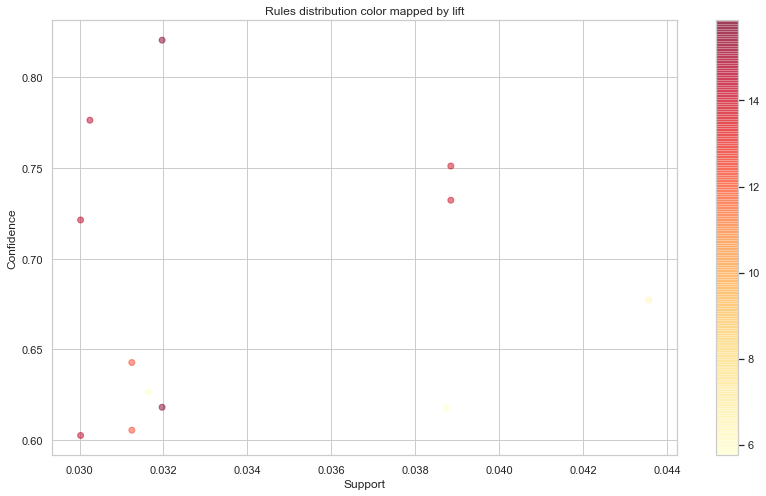

In [83]:
# Visualizing the rules distribution color mapped by Lift
plt.figure(figsize=(14, 8))
plt.scatter(rules_apriori['support'], rules_apriori['confidence'], c=rules_apriori['lift'], alpha=0.5, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift');
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar();

### Applying FP Growth Algorithm

In [70]:
# compute the frequent itemsets using fpgrowth from mlxtend
# min_support is calculated based on the occurance of the product divided by total number of transactions
# For example, Product A occurs 10 times in a day and in week it occurs 70 times which is divided by total transactions (18018) i.e. 0.003

frequent_itemsets = fpgrowth(basket_uk, min_support=0.003, use_colnames = True)

# print the frequent itemsets
frequent_itemsets

,support,itemsets
0,0.119991,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.024864,(KNITTED UNION FLAG HOT WATER BOTTLE)
2,0.022811,(RED WOOLLY HOTTIE WHITE HEART.)
3,0.018870,(SET 7 BABUSHKA NESTING BOXES)
4,0.016428,(WHITE METAL LANTERN)
...,...,...
369344,0.003275,"(LUNCH BAG RED VINTAGE DOILY, VINTAGE DOILY JU..."
369345,0.003108,"(LUNCH BAG PAISLEY PARK, LUNCH BAG RED VINTAGE..."
369346,0.003275,"(BICYCLE PUNCTURE REPAIR KIT, CLASSIC CHROME B..."
369347,0.004163,"(CLASSIC BICYCLE CLIPS, BICYCLE PUNCTURE REPAI..."


In [75]:
# Compute the association rules based on the frequent itemsets


# compute and print the association rules
rules_fp_growth=association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules_fp_growth.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(WOODEN PICTURE FRAME WHITE FINISH, KNITTED UN...",(WHITE HANGING HEART T-LIGHT HOLDER),0.004773,0.119991,0.003164,0.662791,5.523665,0.002591,2.609682
1,"(KNITTED UNION FLAG HOT WATER BOTTLE, RETROSPO...",(CHOCOLATE HOT WATER BOTTLE),0.005828,0.045510,0.003996,0.685714,15.067317,0.003731,3.037013
2,"(PAPER CHAIN KIT VINTAGE CHRISTMAS, KNITTED UN...",(PAPER CHAIN KIT 50'S CHRISTMAS),0.004607,0.062438,0.004052,0.879518,14.086361,0.003764,7.781768
3,"(KNITTED UNION FLAG HOT WATER BOTTLE, PAPER CH...",(PAPER CHAIN KIT VINTAGE CHRISTMAS),0.006216,0.044400,0.004052,0.651786,14.679844,0.003776,2.744287
4,"(JAM MAKING SET PRINTED, KNITTED UNION FLAG HO...",(JUMBO BAG RED RETROSPOT),0.004329,0.107393,0.003108,0.717949,6.685271,0.002643,3.164699


In [95]:
rules_fp_growth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
1186888,"(RED RETROSPOT PEG BAG, ROUND SNACK BOXES SET ...","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...",0.003053,0.901639,270.762295
1186430,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...","(RED RETROSPOT PEG BAG, ROUND SNACK BOXES SET ...",0.003053,0.916667,270.762295
1186376,"(RED RETROSPOT CHARLOTTE BAG, ROUND SNACK BOXE...","(RED RETROSPOT PEG BAG, CHILLI LIGHTS, STRAWBE...",0.003053,0.948276,266.969289
1186942,"(RED RETROSPOT PEG BAG, CHILLI LIGHTS, STRAWBE...","(RED RETROSPOT CHARLOTTE BAG, ROUND SNACK BOXE...",0.003053,0.859375,266.969289
1186931,"(RED RETROSPOT PEG BAG, CHARLOTTE BAG SUKI DES...","(RED RETROSPOT CHARLOTTE BAG, ROUND SNACK BOXE...",0.003053,0.873016,266.610169
1186387,"(RED RETROSPOT CHARLOTTE BAG, ROUND SNACK BOXE...","(RED RETROSPOT PEG BAG, CHARLOTTE BAG SUKI DES...",0.003053,0.932203,266.610169
1186907,"(RED RETROSPOT PEG BAG, ROUND SNACK BOXES SET ...","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...",0.003053,0.916667,266.395161
1184190,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...","(RED RETROSPOT PEG BAG, STRAWBERRY CHARLOTTE B...",0.003053,0.916667,266.395161
1187194,"(RED RETROSPOT PEG BAG, STRAWBERRY CHARLOTTE B...","(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...",0.003053,0.887097,266.395161
1186075,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...","(RED RETROSPOT PEG BAG, ROUND SNACK BOXES SET ...",0.003053,0.916667,266.395161


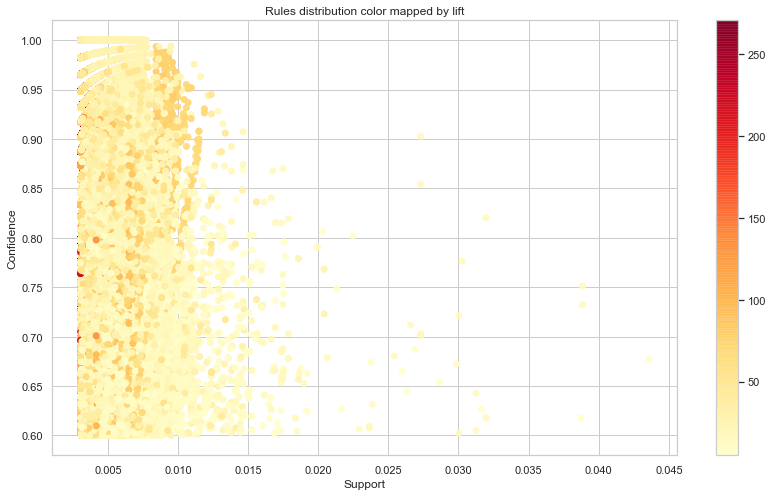

In [77]:
# Visualizing the rules distribution color mapped by Lift
plt.figure(figsize=(14, 8))
plt.scatter(rules_fp_growth['support'], rules_fp_growth['confidence'], c=rules_fp_growth['lift'], alpha=0.5, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift');
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar();

### Conclusion

The FP Growth algorithm performs better when compared to Apriori algorithm in terms of execution time of rules and memory utilization.

From the Apriori algorithm with min_support=0.03, the “Pink regency teacup and saucer” and “Green regency teacup and saucer” itemset has confidence of 0.82 and lift as 15.8. Which shows that out of all transactions that contain pink regency teacup and saucer, 82% of the transactions are likely to contain green regency teacup and saucer. And Green regency teacup and saucer is 15.8 times more likely to be bought by the customers that bought pink regency teacup and saucer, compared to its default sale.

From the FP Growth algorithm with min_support=0.003, the “Red retrospot peg bag” and “Red retrospot charlotte bag” has confidence of 0.90 and lift as 270. Which shows that out of all transactions that contain red retrospot peg bag, 90% of the transactions are likely to contain red retrospot charlotte bag as well. And the red retrospot charlotte bag is 270 times more likely to be bought by the customers that bought red retrospot peg bag.

